# Health Authority Proposal (Data 551)

### Group Members ###
**Andrew Nguyen <br>
Anqi Li <br>
Kevin Radford <br>
Monica Penner**

In [1]:
# Required packages
library(tidyverse)
library(readxl)
library(hexbin)
library(ggthemes)
library(repr)
library(lubridate)
library(stringr)
library(reshape2)
library(gridExtra)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.4     v dplyr   1.0.8
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.1.1     v forcats 0.5.1

Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.2"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'hexbin' was built under R version 4.1.2"
Warning message:
"package 'ggthemes' was built under R version 4.1.2"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message:
"package 'reshape2' was built under R version 4.1.2"

Attaching package: 'reshape2'


The following object is masked from 'package:

# 1. Description of Data

### Data Set: "BC Quarterly Surgical Wait Times"

Source: [https://catalogue.data.gov.bc.ca/dataset/bc-surgical-wait-times/resource/f294562c-a6fd-4d7f-8f99-c51c91891c67](https://catalogue.data.gov.bc.ca/dataset/bc-surgical-wait-times/resource/f294562c-a6fd-4d7f-8f99-c51c91891c67)

This dataset contains the B.C. surgical wait times for elective surgical procedures in British Columbia for patients of all ages. This data includes scheduled inpatient and day surgery cases. This data does not include unscheduled surgical cases. The data is collected quarterly from fiscal year 2009/10 to current year. The dataset has the following variables:

1. **Waiting** : The number of surgical cases waiting at the end of the preceding fiscal quarter 
2. **Completed**: The number of surgical cases completed within each quarter.
3. **Health authority**: The health authority of the hospital from where data is collected.
4. **Hospital name**: The name of the hospital where the surgical procedures are performed.
5. **Procedure group**: The name of the surgical procedure type.
6. **Completed 50th percentile**: For completed procedures, the number of weeks 50% of the patients waited for surgery.
7. **Completed 70th percentile**: For completed procedures, the number of weeks 90% of the patients waited for surgery.


# 2. Data Loading

Data is loaded and the first two lines are displayed below to get better understand of the variables.  

In [14]:
path <- 'data/2009_2021-quarterly-surgical_wait_times.xlsx'
data09 <- read_excel(path)
head(data09,2)

FISCAL_YEAR,QUARTER,HEALTH_AUTHORITY,HOSPITAL_NAME,PROCEDURE_GROUP,WAITING,COMPLETED,COMPLETED_50TH_PERCENTILE,COMPLETED_90TH_PERCENTILE
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2009/10,Q1,All Health Authorities,All Facilities,Abdominoplasty,65,21,8.1,73.4
2009/10,Q1,All Health Authorities,All Facilities,All Other Procedures,1561,1865,4.0,15.9


In [15]:
path <- 'data/2021_2022-quarterly-surgical_wait_times-q3-interim.xlsx'
data21 <- read_excel(path)
head(data21,2)

FISCAL_YEAR,QUARTER,HEALTH_AUTHORITY,HOSPITAL_NAME,PROCEDURE_GROUP,WAITING,COMPLETED,COMPLETED_50TH_PERCENTILE,COMPLETED_90TH_PERCENTILE
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2021/22,Q1,All Health Authorities,All Facilities,Abdominoplasty,118,50,9.9,77.1
2021/22,Q1,All Health Authorities,All Facilities,All Other Procedures,1418,1771,4.0,18.0


In [16]:
# append 2021/2022 interim data to 2009/2021 historical data
qdata <- rbind(data09, data21)

# 3. Data Exploration

### General Observations 
1) Waiting and completed values are counts
2) Percentile values are in weeks
3) For privacy reasons, counts less than 5 have been grouped and given the value "<5".
4) The dataset comes with rows grouped for All Authorities, All Facilities and All Procedures.  These contain the summation values (count columns) and mean values (percentile columns) of the data for their respective columns.  
5) There are many blank entries in the dataset which were coerced to NA in the cleaning steps.  Upon direct inspection of the dataset, all the missing values are located in the two percentile columns, predominantly where waiting and completed counts are lowest. 
6) The first quarter begins April 1st and the last quarter end March 31 of the following year. [1](https://www.interiorhealth.ca/sites/default/files/PDFS/audited-financial-statements-2021.pdf)

### Dimension of data
The combined dataset has 160692 observations and 9 variables.

In [17]:
# check dimension and numerical statistics.  Note count variables are non-numeric
dim(data09)
dim(data21)
dim(qdata)

[1] 151277      9

[1] 9415    9

[1] 160692      9

### Column rename
Convert column names to lowercase, simplify and clarify.

In [18]:
# Cleaned column names
colnames(qdata) <- tolower(colnames(qdata))
qdata <- qdata %>%
    rename(year = fiscal_year,
           hospital = hospital_name,
           procedure = procedure_group,
           wait_time_50 = completed_50th_percentile,
           wait_time_90 = completed_90th_percentile)
head(qdata, 2)

year,quarter,health_authority,hospital,procedure,waiting,completed,wait_time_50,wait_time_90
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2009/10,Q1,All Health Authorities,All Facilities,Abdominoplasty,65,21,8.1,73.4
2009/10,Q1,All Health Authorities,All Facilities,All Other Procedures,1561,1865,4.0,15.9


### Change datatype of columns
The corrected datatype is assigned to columns as follows

In [19]:
#convert <5 string to median value of 3
qdata <- mutate_if(qdata, is.character, str_replace_all, pattern = "<5", replacement = "3")

# correct datatypes of columns, simplify fiscal year to year at start of first quarter
qdata$waiting <- as.numeric(qdata$waiting)
qdata$completed <- as.numeric(qdata$completed)
qdata$year <- qdata$year %>% str_replace('(/).*', "")
head(qdata,2)

year,quarter,health_authority,hospital,procedure,waiting,completed,wait_time_50,wait_time_90
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2009,Q1,All Health Authorities,All Facilities,Abdominoplasty,65,21,8.1,73.4
2009,Q1,All Health Authorities,All Facilities,All Other Procedures,1561,1865,4.0,15.9


### Dealing with missing values
NA values will be removed from our main dataset.

To retain wait and complete counts that do not have associated wait time values, a separate "count" dataset will be created for further cleaning and analysis specifically focused on the counts of waiting and completed cases. 

In [20]:
# check for NA's
data.frame(colSums(is.na(qdata)))

,colSums.is.na.qdata..
,<dbl>
year,0
quarter,0
health_authority,0
hospital,0
procedure,0
waiting,0
completed,0
wait_time_50,58459
wait_time_90,58459


In [21]:
# drop rows with NA's
clean <- qdata %>% 
    drop_na() #%>% 
    #filter(waiting !=0, completed != 0, completed_50th_percentile != 0, completed_90th_percentile != 0) 
data.frame(colSums(is.na(clean)))

,colSums.is.na.clean..
,<dbl>
year,0
quarter,0
health_authority,0
hospital,0
procedure,0
waiting,0
completed,0
wait_time_50,0
wait_time_90,0


In [22]:
#create counts dataset
count <- select(qdata, -wait_time_50, -wait_time_90)
count <- count %>% 
    drop_na() 

data.frame(colSums(is.na(count)))

,colSums.is.na.count..
,<dbl>
year,0
quarter,0
health_authority,0
hospital,0
procedure,0
waiting,0
completed,0


### Data subsetting
There is a large difference in between the mean and median of the waiting and completed variables.  This reflects the inclusion of summation rows for "All Health Authorities", "All Facilities" and "All Procedures".  These redundant summation rows will be removed and stored in a separate "all" dataframe.

In [24]:
main <- clean %>%
            filter(procedure != 'All Procedures', 
                   hospital != 'All Facilities',
                   health_authority != 'All Health Authorities')
count <- count %>%
            filter(procedure != 'All Procedures', 
                   hospital != 'All Facilities',
                   health_authority != 'All Health Authorities')
all <-  clean %>% 
            filter(procedure == 'All Procedures', 
                   hospital == 'All Facilities',
                   health_authority == 'All Health Authorities') 
summary(count)

     year             quarter          health_authority     hospital        
 Length:129676      Length:129676      Length:129676      Length:129676     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  procedure            waiting          completed      
 Length:129676      Min.   :   0.00   Min.   :   0.00  
 Class :character   1st Qu.:   3.00   1st Qu.:   3.00  
 Mode  :character   Median :   6.00   Median :   6.00  
                    Mean   :  32.07   Mean   :  23.32  
                    3rd Qu.:  24.00   3rd Qu.:  21.00  
                    Max.   :3438.00   Max.   :2715.00  

In [25]:
summary(all)

     year             quarter          health_authority     hospital        
 Length:51          Length:51          Length:51          Length:51         
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  procedure            waiting        completed      wait_time_50   
 Length:51          Min.   :69600   Min.   :36753   Min.   : 5.000  
 Class :character   1st Qu.:75745   1st Qu.:56230   1st Qu.: 5.700  
 Mode  :character   Median :79357   Median :58938   Median : 6.100  
                    Mean   :80795   Mean   :58524   Mean   : 6.447  
                    3rd Qu.:85921   3rd Qu.:62159   3rd Qu.: 7.100  
                    Max.   :95575   Max.   :707

In [26]:
summary(main)

     year             quarter          health_authority     hospital        
 Length:74662       Length:74662       Length:74662       Length:74662      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
  procedure            waiting          completed        wait_time_50    
 Length:74662       Min.   :   0.00   Min.   :   5.00   Min.   :  0.000  
 Class :character   1st Qu.:   7.00   1st Qu.:   9.00   1st Qu.:  3.100  
 Mode  :character   Median :  18.00   Median :  18.00   Median :  5.600  
                    Mean   :  52.88   Mean   :  38.75   Mean   :  8.446  
                    3rd Qu.:  50.00   3rd Qu.:  38.00   3rd Qu.: 10.600  
                 

### Dataset compositions and basic statistics
Because the original dataset contains summation data and percentile variables with a high number of missing values, to retain the most data in a functional format, three unique datasets each containing **quarterly data** from 2009 to 2022 have been created. 
- The _"count"_ dataset focuses on waiting and completed case counts and has 129676 rows. It is reduced to 7 variables with percentile variables excluded to preserve low value waiting and completed case counts which would otherwise be excluded. Each observation represents data for a unique procedure at a specific hospital. 
    - Mean number of cases at the end of each quarter waiting = 37, completed = 23
- The _"all"_ dataset isolates summation data with 51 rows (4 quarters x 12 3/4 years) and all 9 original variables. Each observation represents province wide data.
    - Mean number of cases at the end of each quarter waiting = 80795, completed = 58524
    - Average wait-time in weeks for 50th percentile = 6.4, 90th percentile = 29.9       
- The _"main"_ dataset contains 74662 rows of unique observations and 9 columns. Each observation represents data for a unique procedure at a specific hospital, however many low volume procedures/hospital observations have been excluded for lack of corresponding percentile/wait-time data. 
    - Within this dataset there are:
        - **six health authorities** spanning the entire province of British Columbia.
        - **60 hospitals** within these six health authorities.
        - **83 surgical procedure** types performed at these hospitals.
    - Mean number of cases waiting = 52, completed = 39
    - Average wait-times in weeks for 50th percentile = 8.4, 90th percentile = 21.9

In [28]:
unique(main$health_authority)

[1] "Fraser"                              
[2] "Interior"                            
[3] "Northern"                            
[4] "Provincial Health Services Authority"
[5] "Vancouver Coastal"                   
[6] "Vancouver Island"

In [29]:
length(unique(main$hospital))

[1] 60

In [30]:
length(unique(main$procedure))

[1] 83

# 4. Initial Thoughts

The dataset provides BC surgical data on a quarterly basis. The waiting column can be categorized as representing the number of patients on a surgical **wait-list** at the end of each quarter.  The number of completed cases can be categorized as representing the work done or **efficiency** for each procedure at each hospital during that quarter.  The percentile information can be categorized as representing the **wait-time** in weeks for cases completed during that quarter. 

Health literature repeatedly demonstrates that prolonged surgical wait-times are detrimental to patient health. [[2]("https://www.policyalternatives.ca/sites/default/files/uploads/publications/BC%20Office/2016/04/ccpa-bc_ReducingSurgicalWaitTimes_summary.pdf")], [[3]("https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1959190/")]  It follows that having reduced wait-lists and increased efficiency is associated with reduced wait-times and improved health outcomes.[[4]("https://pubmed.ncbi.nlm.nih.gov/27603225/")]  To explore these concepts further there are many questions that this robust dataset could answer, here are but a few.

Questions.
1. Are there any trends in wait-list and efficiency numbers throughout the year, across years or across health authorities?

2. Is there any relationship between wait-lists and efficiencies across the province?

3. Are all health authorities and hospitals equally efficient? The wide range in our min and max summary statistics would suggest not.  Where are there great successes and where are there challenges?

4. There are 83 unique procedures performed within the province.  What are the differences in wait-times between procedure groups? 

5. There are international maximum wait-time guidelines set for many surgical procedures [[5]("https://www2.gov.bc.ca/gov/content/health/accessing-health-care/surgical-wait-times")]. Are there any procedure group that are not being completed in a timely manner?

6.  Covid has resulted in public health restrictions for society and the healthcare system. [[6]]("https://bc.ctvnews.ca/scroll-through-this-timeline-of-the-1st-year-of-covid-19-in-b-c-1.5284929") Are there any variations within this surgical data that may be associated with the pandemic. 

# 5. Data Wrangling
Further wrangling is needed to get the data in proper shape for our intended analysis and visualization.

### Data filtered to include only most recent 4 years

In [31]:
#data will be subset to include only the most recent year from 2017 to 2020. 
recent <- main %>% 
            filter(year >= 2017)
count_recent <- count %>%
            filter(year >= 2017)

### Data grouped by health authority

In [32]:
# group by health authorities
authority <- count_recent %>% 
    group_by(health_authority, year, quarter) %>% 
    summarise(total_waiting = sum(waiting), total_completed = sum(completed)) %>% 
    arrange(desc(total_waiting))
head(authority,2)

`summarise()` has grouped output by 'health_authority', 'year'. You can
override using the `.groups` argument.


health_authority,year,quarter,total_waiting,total_completed
<chr>,<chr>,<chr>,<dbl>,<dbl>
Fraser,2019,Q3,28558,17327
Fraser,2019,Q2,27847,15900


### Health Authority Data with calculated completed case ratio

In [33]:
authority_ratio <- authority %>% 
    unite(time, year,quarter, sep = "")%>%
    mutate(ratio = total_completed/(total_completed+total_waiting))
head(authority_ratio)

health_authority,time,total_waiting,total_completed,ratio
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Fraser,2019Q3,28558,17327,0.3776180
Fraser,2019Q2,27847,15900,0.3634535
Fraser,2020Q1,27361,10094,0.2694967
Fraser,2019Q4,27067,16095,0.3728975
Fraser,2019Q1,26934,17786,0.3977191
Fraser,2018Q4,26405,17154,0.3938107


### Data Grouped by Hospital for Northern Health

In [44]:
# group Hospital within Northern Health Authority
hospital_fraser <- count_recent %>% 
    filter(health_authority == "Fraser") %>%
    group_by(hospital, year, quarter) %>% 
    summarise(total_waiting = sum(waiting), total_completed = sum(completed)) %>% 
    arrange(desc(total_waiting))
head(hospital_fraser,2)

`summarise()` has grouped output by 'hospital', 'year'. You can override using
the `.groups` argument.


hospital,year,quarter,total_waiting,total_completed
<chr>,<chr>,<chr>,<dbl>,<dbl>
Surrey Memorial Hospital,2021,Q1,6833,2332
Surrey Memorial Hospital,2021,Q2,6319,2717


In [45]:
hospital_fraser_melted <- melt(hospital_fraser) %>% 
    unite(time, year,quarter, sep = "")

head(hospital_fraser_melted, 2)

Using hospital, year, quarter as id variables



,hospital,time,variable,value
,<chr>,<chr>,<fct>,<dbl>
1,Surrey Memorial Hospital,2021Q1,total_waiting,6833
2,Surrey Memorial Hospital,2021Q2,total_waiting,6319


### Data grouped by procedure group

In [61]:
#Cataract Surgery is a unique high volume procedure often performed in seperate OR facilities and will be excluded from a part of the analysis.
no_cataract_fraser <- recent %>% 
            filter(procedure != 'Cataract Surgery',
                  health_authority == 'Fraser')  

In [62]:
# by procedure group
procedure <- no_cataract_fraser %>% 
    group_by(procedure, year, quarter) %>% 
    summarise(wait_time_50 = mean(wait_time_50), wait_time_90 = mean(wait_time_90)) %>% 
    arrange(desc(wait_time_90))
head(procedure, 2)

`summarise()` has grouped output by 'procedure', 'year'. You can override using
the `.groups` argument.


procedure,year,quarter,wait_time_50,wait_time_90
<chr>,<chr>,<chr>,<dbl>,<dbl>
Mastoidectomy,2020,Q4,99.7,120.3
Hernia Repair - Hiatal,2017,Q1,2.0,117.0


In [63]:
procedure_unite <- procedure %>% 
    unite(time, year, quarter, sep = "")
head(procedure_unite)

procedure,time,wait_time_50,wait_time_90
<chr>,<chr>,<dbl>,<dbl>
Mastoidectomy,2020Q4,99.70000,120.3000
Hernia Repair - Hiatal,2017Q1,2.00000,117.0000
Excision Gynecomastia,2019Q4,48.50000,114.3000
Sinus Surgery,2021Q3,39.36667,104.8667
Mastoidectomy,2021Q1,12.00000,93.9000
Tympanoplasty,2020Q3,78.60000,92.9000


### Extracted procedure groups with maximum/minimum waiting time

In [75]:
# most treated and less treated surgeries
procedure_order <- procedure_unite %>% arrange(wait_time_90) %>% pull(procedure) %>% unique()
fastest <- head(procedure_order,5)
slowest <- tail(procedure_order,5)

Procedure groups with longest average 90th percentile waiting times

In [76]:
slowest

[1] "Nasal Surgery"                     "Varicose Veins Ligation/Stripping"
[3] "Hip Replacement"                   "Knee Replacement"                 
[5] "Breast Reduction"

Procedure groups with shortest average 90th percentile waiting times.

In [77]:
fastest

[1] "Ligament Surgery"             "Foreign Body Removal Surgery"
[3] "Esophagectomy"                "Scope of Chest"              
[5] "Thoracotomy"

# 6. Data Analysis and Visulaizations

### 1. Total waiting and completed cases between 2009 and 2021 by quarter

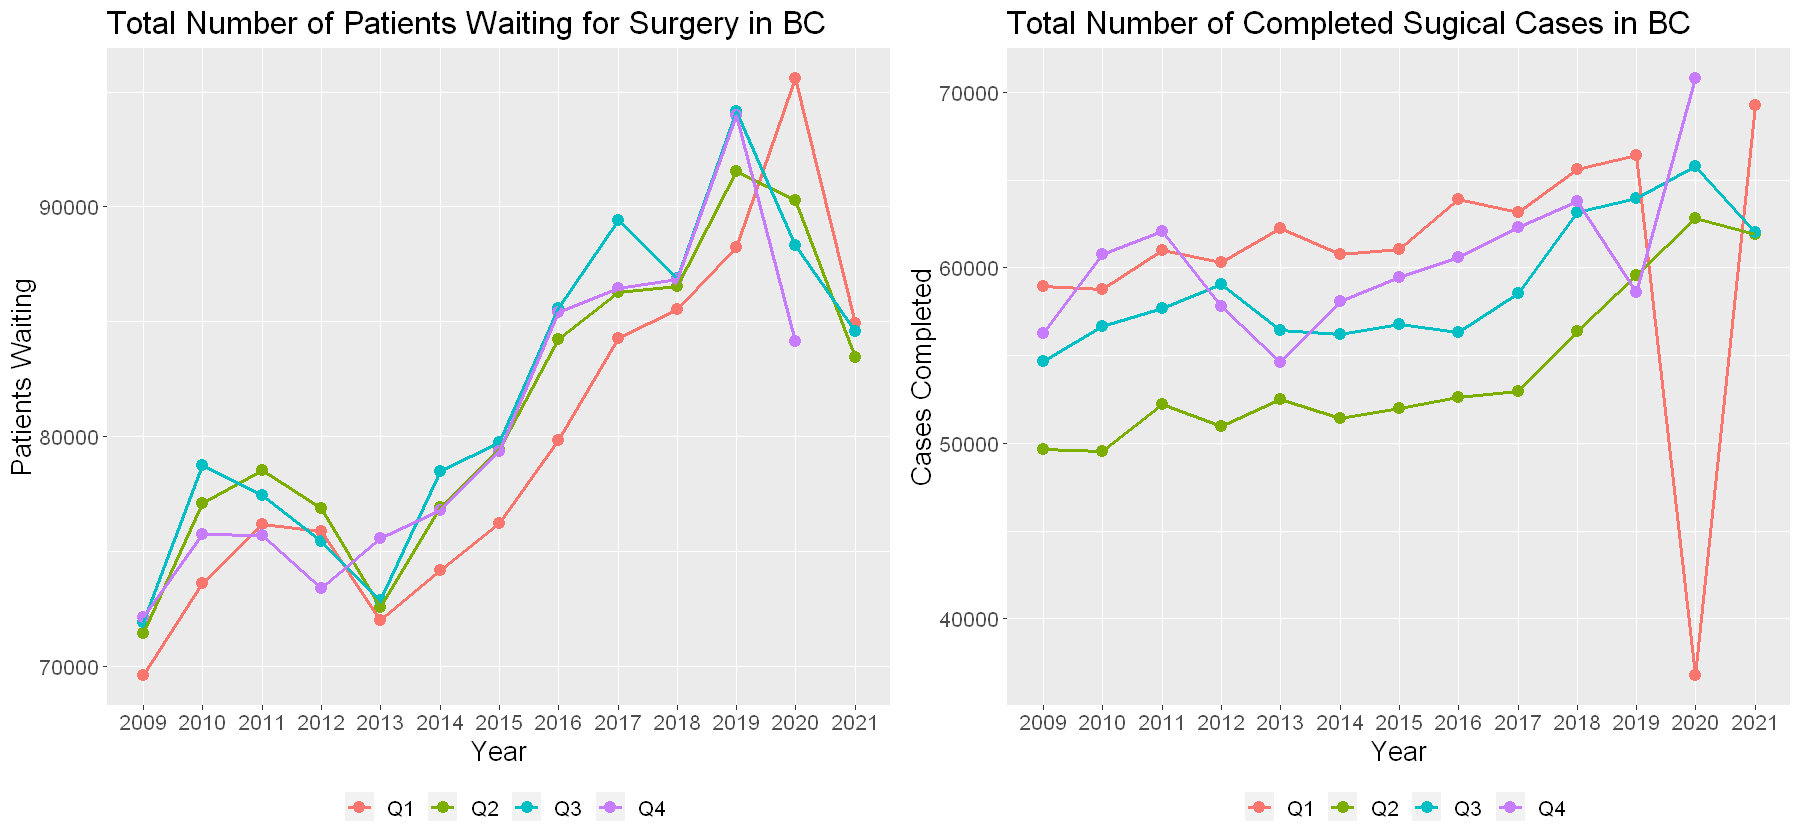

In [78]:
plot1a <- ggplot(all)+
        aes(x = year,
        y = waiting,
           color = quarter)+
    geom_point(size = 3)+
    geom_line(
        aes(group = quarter), size =1)+
    #theme_minimal()+    I just commented this out to keep same theme for all the graphs but if you we can choose this theme for all the graphs
    labs(x = "Year", y = "Patients Waiting", color = "")+ 
    ggtitle("Total Number of Patients Waiting for Surgery in BC")+
    theme(
        legend.position = "bottom",
        text = element_text(size=16)) 

options(repr.plot.width=8, repr.plot.height=8)
plot1b <- ggplot(all)+
        aes(x = year,
        y = completed,
           color = quarter)+
    geom_point(size = 3)+
    geom_line(
        aes(group = quarter), size = 1)+
    #theme_minimal()+
    labs(x = "Year", y = "Cases Completed", color = "")+ 
    ggtitle("Total Number of Completed Sugical Cases in BC")+
    theme(
        legend.position = "bottom",
        text = element_text(size=16))

options(repr.plot.width=15, repr.plot.height=7)
plot1 <- grid.arrange(plot1a, plot1b, ncol = 2)  

**Analysis**: To check for annual, quarterly and/or covid related variations in wait-lists and completed cases, summation data for all health authorites and all procedures has been plotted by quarter over all the years.  Trends include:
- Excluding 2013, there is a gradual, consistant increase in the number of patients on surgical waitlists with a smaller trend of increasing numbers of completed cases until 2019 at which point the trend is lost.  
- Pandemic shut downs began in the first quart of 2020. This corresponds to markedly different values for the waiting and completed counts when compared to the trends for the preceding decade.
- Excluding the 2020/21 time period, generally more surgeries are completed in the first and fourth quarter (approximately April through June and January through March respectively) than in the second quarter (approximately July through August).  This is may be related to summer vacations.
Let's delve deeper into specific health authorities and narrow our timeline to include only the last four years and look at the ratio of completed cases relative to waiting plus completed cases. 

### 2. Efficiency of different health authorities since 2017

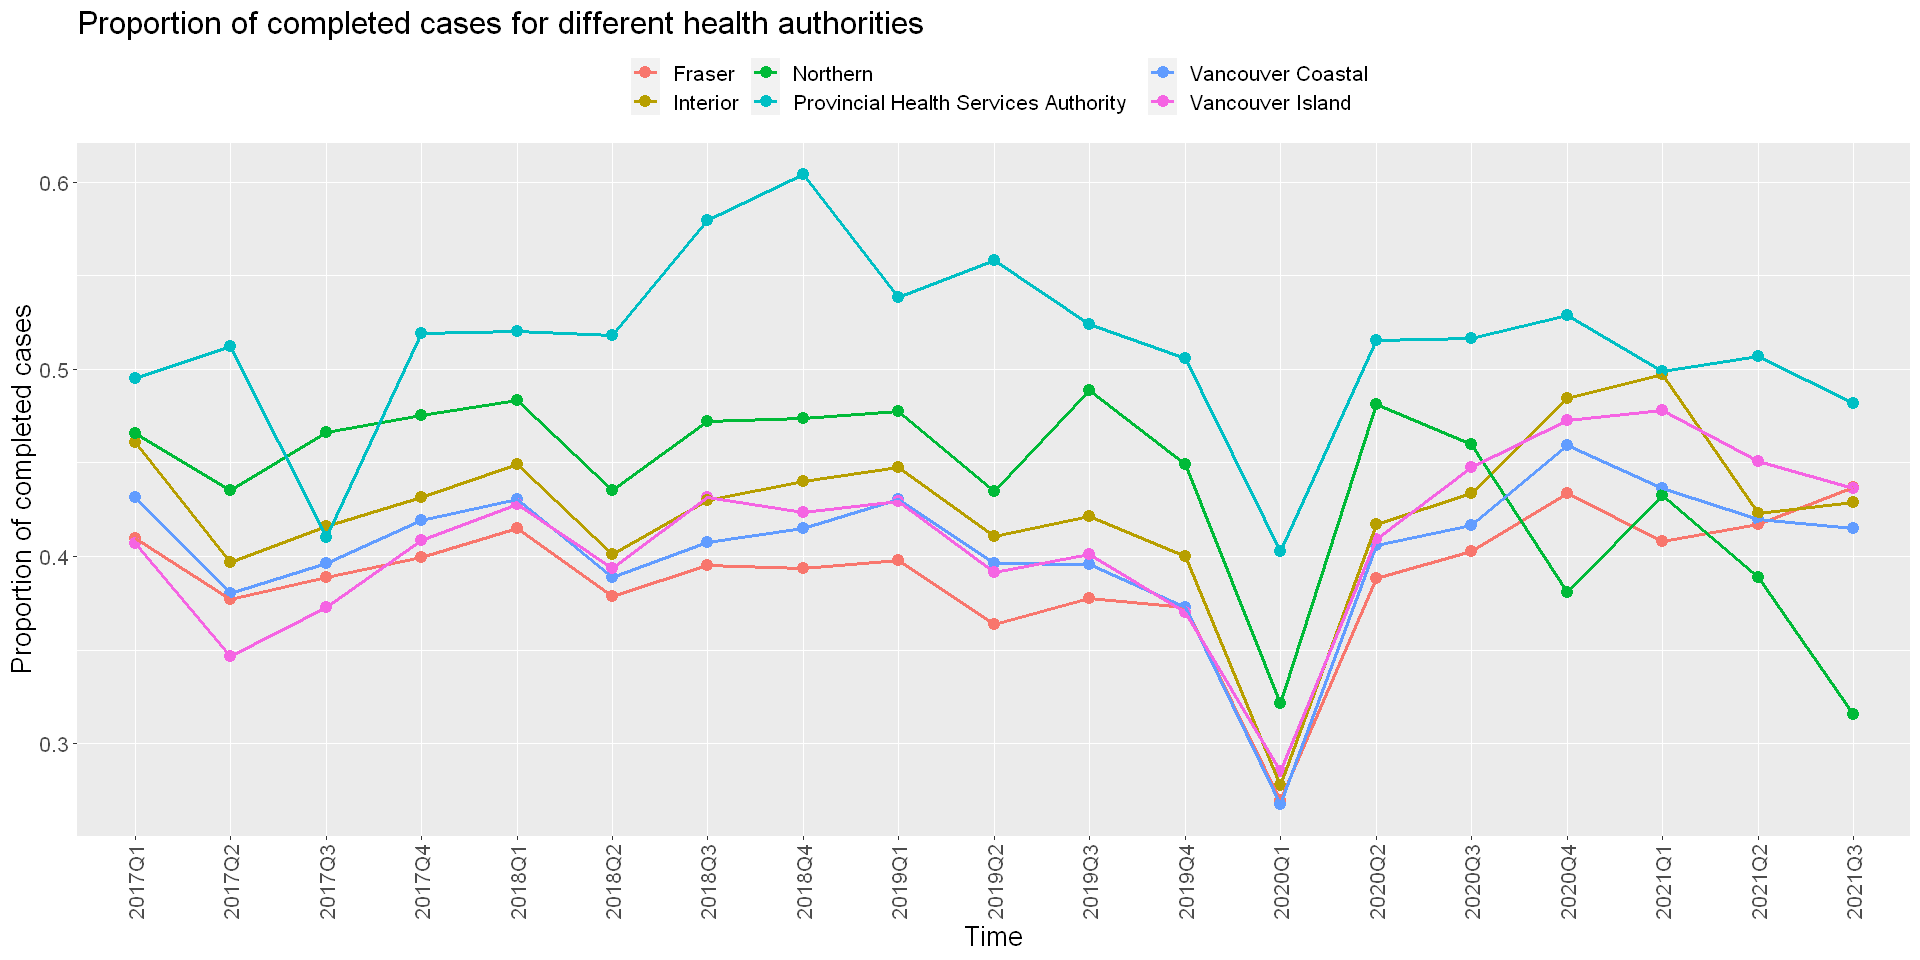

In [79]:
options(repr.plot.width=16, repr.plot.height=8)
plot2 <- authority_ratio %>% 
    ggplot(. , aes(y = ratio, x = time, group = health_authority, color = health_authority))+ 
    geom_point(size =3)+
    geom_line(aes(y = ratio, x = time, color = health_authority), size = 1)+
    labs(y = "Proportion of completed cases", x = 'Time', title = "Proportion of completed cases for different health authorities", color = "")+
    theme(text = element_text(size=16), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), legend.position = "top")
plot2

**Analysis**: To check the efficiency of different health authorities, we have computed the proportion of completed cases as `proportion = (completed)/(completed + waiting)` i.e. 0.5 proportion represents that 50% of total counted cases were completed in that quarter. Thus, an authority with a higher proportion would be completing more surgeries relative to the number of surgical patients. We can observe from plot2 that Fraser Health Authority has not seen a dramatic change over the last two years  This plot highlights an impressive reduction in efficiency at the 2020 Q1 time point which is associated with the greatest Covid-19 Pandemic shut down.  The unique decrease in surgical efficiency for the Northern and Interior health regions is notable and deserves separate analysis.  

### 3. Number of waiting and completed cases for different hospitals within the Northern health authority

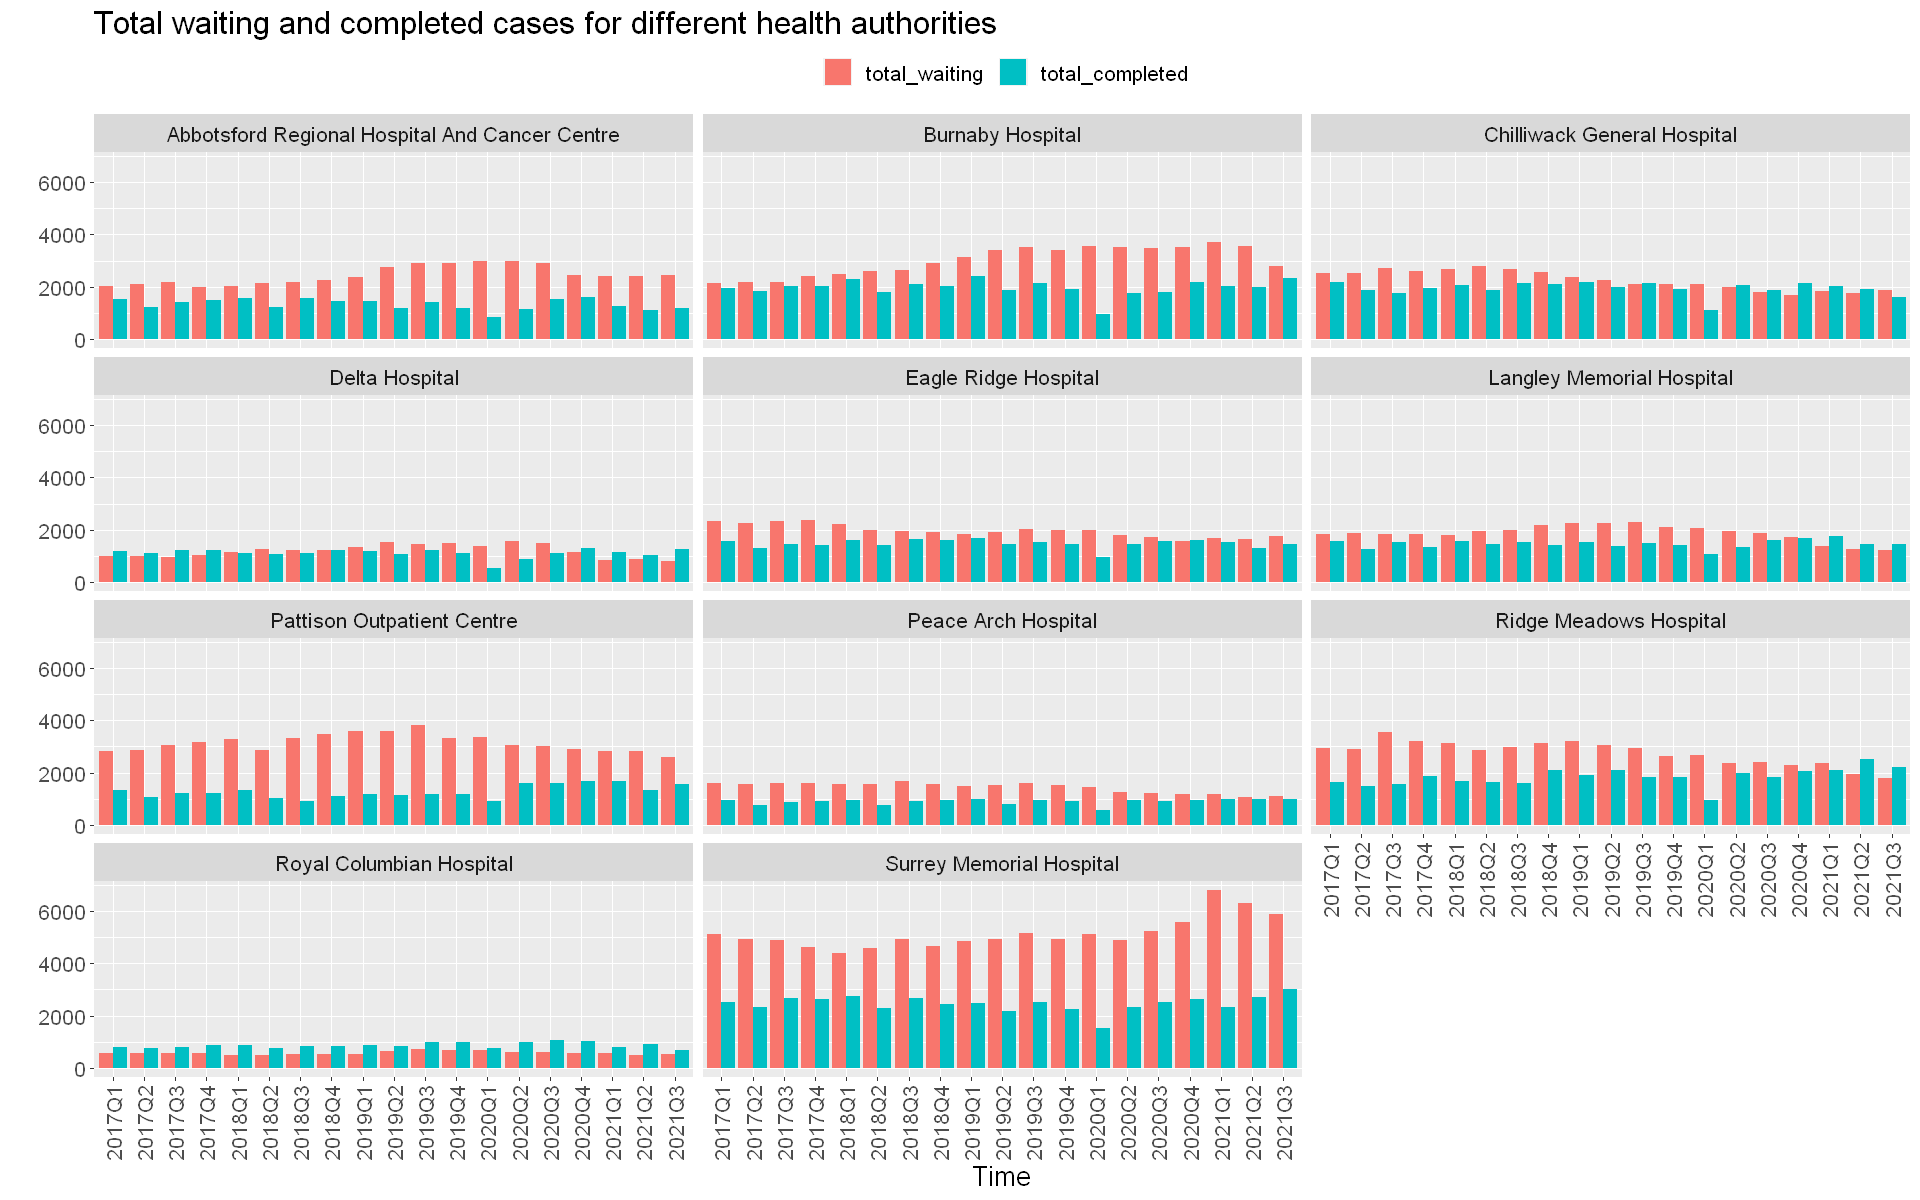

In [80]:
options(repr.plot.width=16, repr.plot.height=10)
plot3  <- hospital_fraser_melted %>% 
        ggplot(. , aes(x = time, y = value, fill = variable))+ 
        geom_bar(stat = "identity", position = 'dodge')+
        labs(y = "", x = 'Time', title = "Total waiting and completed cases for different health authorities", fill = "")+
        theme(text = element_text(size=16), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),legend.position="top")+
        facet_wrap(~hospital, ncol = 3)
plot3

**Analysis**: 
Analyzing the different hospitals within Fraser region total cases completed appears consistant for all sites, however the number of waiting cases at Surrey Memorial Hospital increased during the first quarter of 2021.

### 4) Exploring wait-times in Fraser Health Authority for different procedure groups over the years

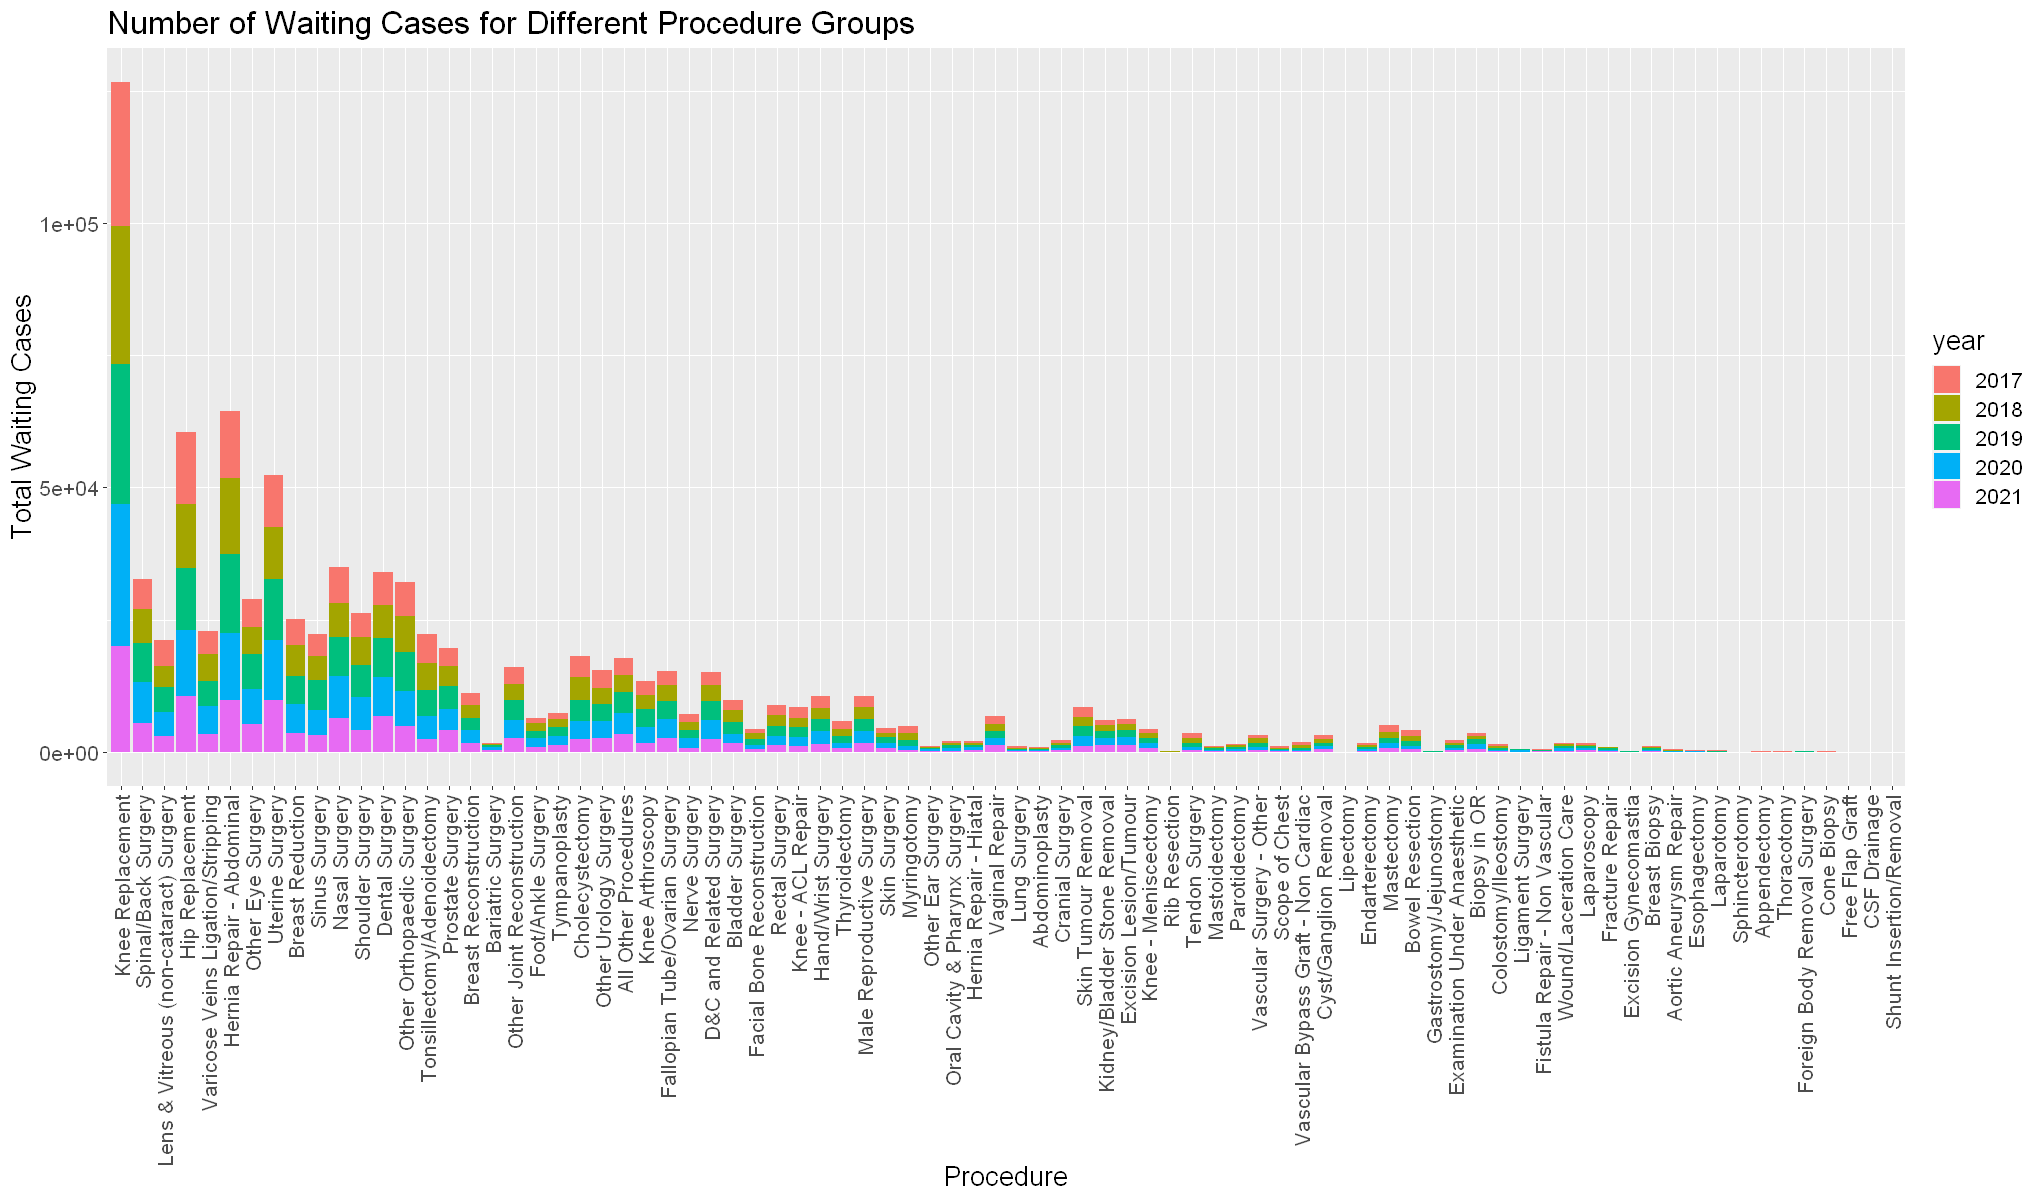

In [81]:
options(repr.plot.width=17, repr.plot.height=10)
plot4 <- ggplot(no_cataract, aes(x = reorder(procedure, -waiting), y = waiting, fill = year))+ 
        geom_bar(stat = "sum", show.legend = c(size=FALSE))+
        labs(y = "Total Waiting Cases", x = "Procedure", title = "Number of Waiting Cases for Different Procedure Groups")+
        theme(text = element_text(size=16), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot4

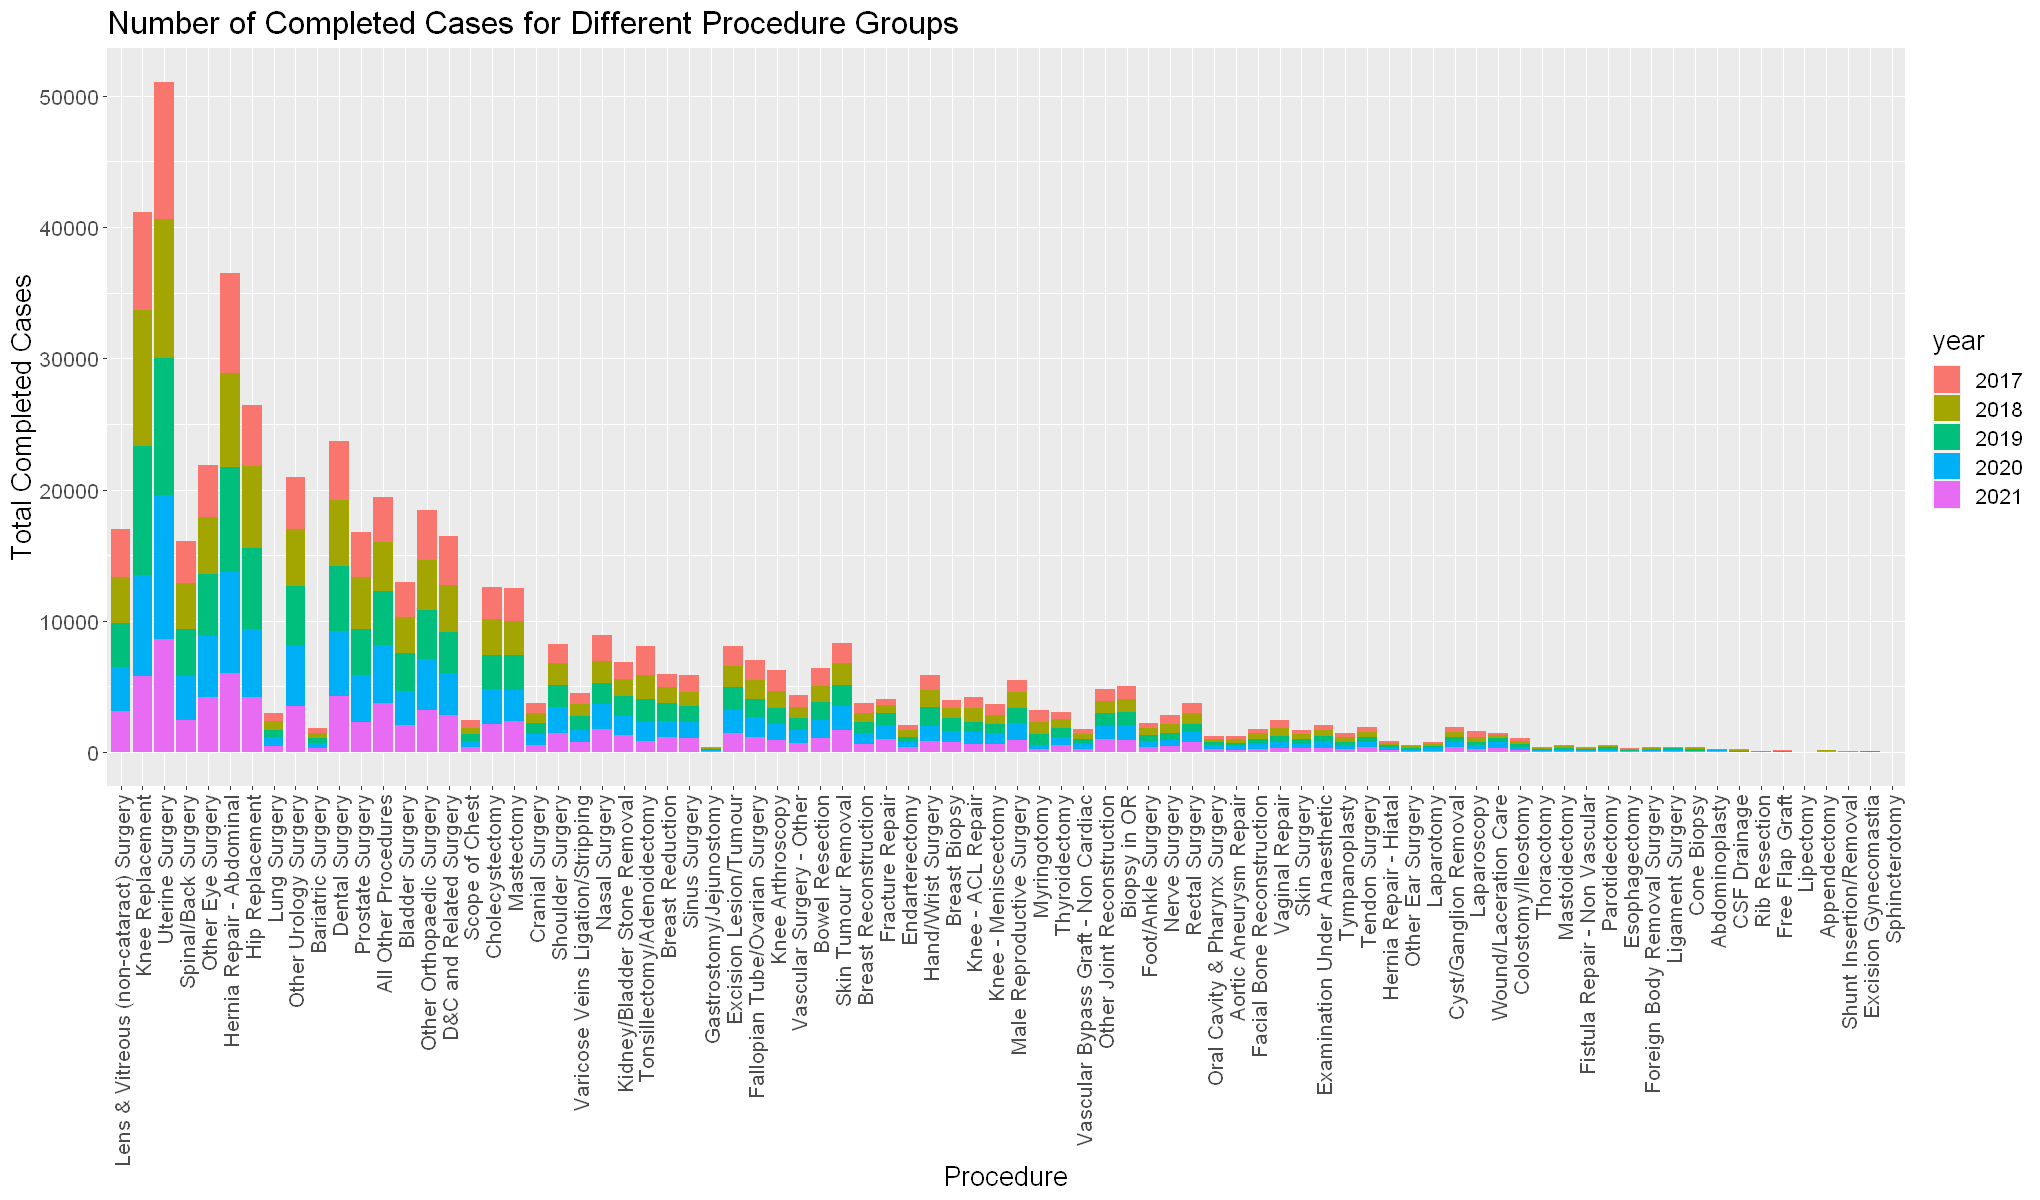

In [82]:
options(repr.plot.width=17, repr.plot.height=10)
plot5 <- ggplot(no_cataract, aes(x = reorder(procedure, -completed), y = completed, fill = year))+ 
        geom_bar(stat = "sum", show.legend = c(size=FALSE))+
        labs(y = "Total Completed Cases", x = "Procedure", title = "Number of Completed Cases for Different Procedure Groups")+
        theme(text = element_text(size=16), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plot5

**Analysis**:  These plot show that there are huge number of waiting cases for some procedures and less number of waiting cases for other procedures, similarly a large number of cases are completed for some procedures and fewer cases are completed for other procedures. 

### 5. Five procedures with shortest wait-times (fastest) and five procedures with longest wait-times (slowest) within Fraser Health Authority

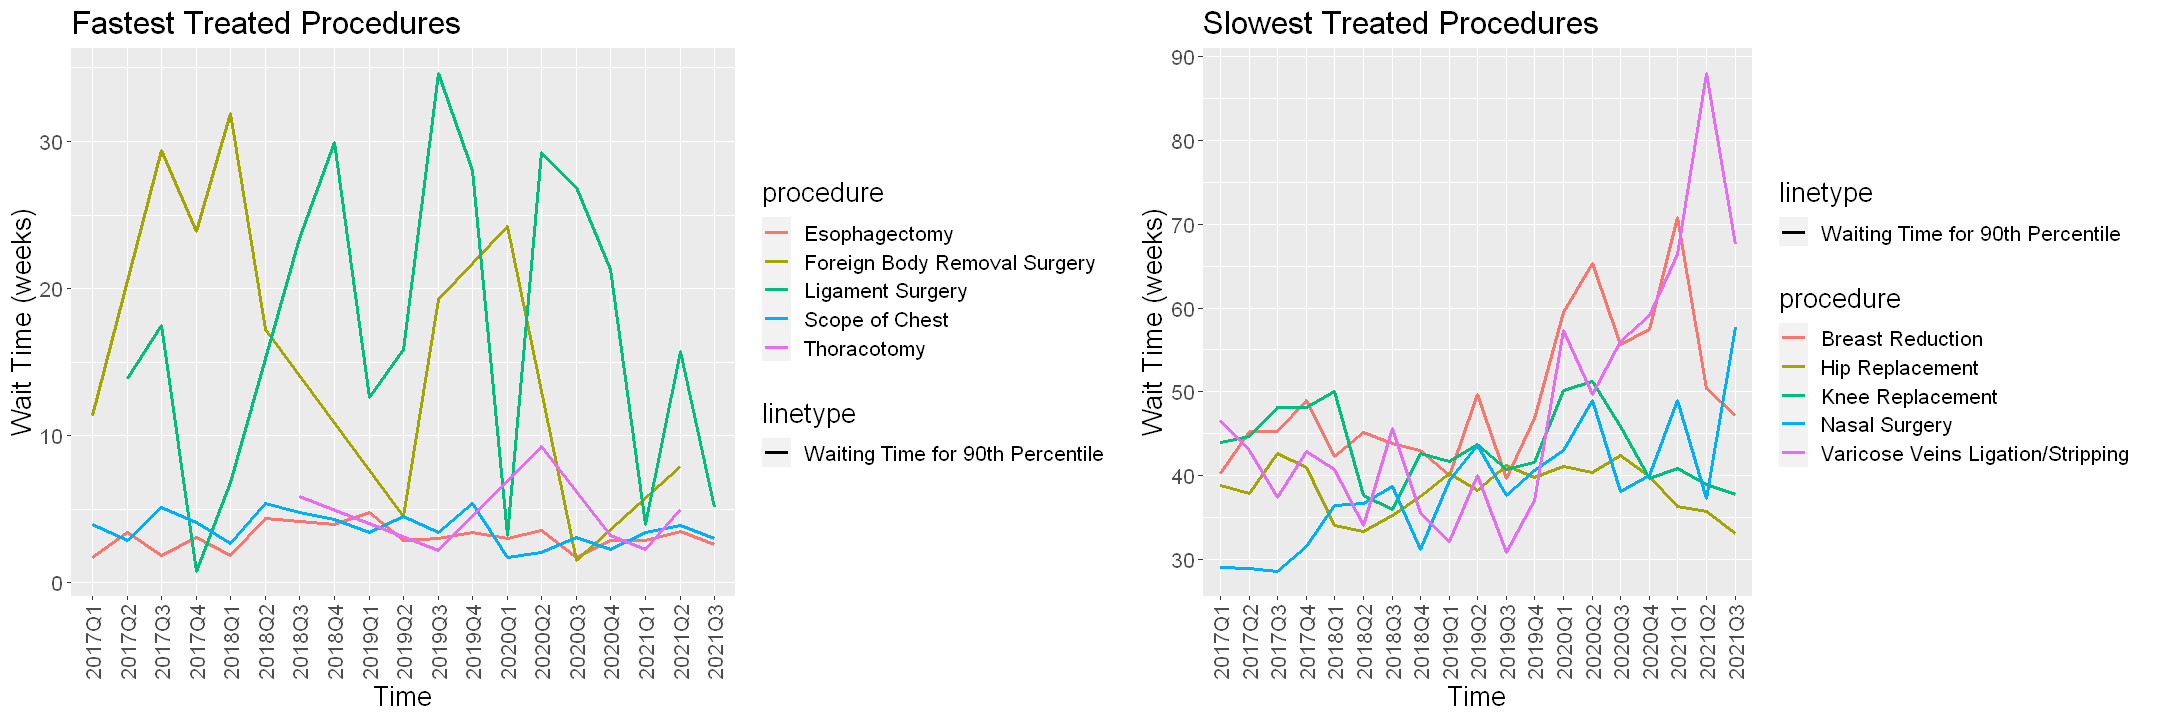

In [83]:
fastest_plot <- procedure_unite %>% filter(procedure %in% fastest) %>%
   ggplot(., aes(x = time, y = wait_time_90, group = procedure, color = procedure, linetype = "Waiting Time for 90th Percentile"))+ 
    geom_line(size = 1)+
    #geom_line(aes(x = time, y = wait_time_50, group = procedure, color = procedure, linetype = "Waiting Time for 50th Perentile"), size = 1)+
    labs(x = "Time", y = "Wait Time (weeks)")+
    ggtitle("Fastest Treated Procedures")+
    theme(text = element_text(size=16), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

slowest_plot <- procedure_unite %>% filter(procedure %in% slowest) %>%
   ggplot(., aes(x = time, y = wait_time_90, group = procedure, color = procedure, linetype = "Waiting Time for 90th Percentile"))+ 
    geom_line(size = 1)+
    #geom_line(aes(x = time, y = wait_time_50, group = procedure, color = procedure, linetype = "Waiting Time for 50th Perentile"), size = 1)+
    labs(x = "Time", y = "Wait Time (weeks)")+
    ggtitle("Slowest Treated Procedures")+
    theme(text = element_text(size=16), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

options(repr.plot.width=18, repr.plot.height=6)
viz5 <- grid.arrange(fastest_plot, slowest_plot, ncol = 2, widths = c(1.1,1))

**Analysis**: These plots demonstrate the ten surgical procedures with the shortest 50th percentile wait time (fastest)  and the ten surgical procedures with the longest 50th percentile wait time (slowest). The left panel depict what could be considered more urgent procedures while the right panel depicts more elective type surgical procedures. As expected more urgent type procedures are completed more quickly (generally fall below 30 weeks) while less urgent type procedures average wait times are all above 25 weeks.
For the fastest, more urgent, completed surgeries, there appears to be little change in wait-times associated with the onset of the pandemic. However, the slowest, more elective, completed procedures appear to have a shift in waitimes associated with the onset of the pandemic. 

# 7. Summary and Conclusions

This dataset contains a wealth of data related to surgeries with British Columbia. After analyzing the data and plots, the following conclusions can be made:

1. Each quarter there are more patients waiting for surgeries than the number of surgeries completed within each quarter.

2. There are differences in how efficiently health authorities clear surgical cases. In Fraser Health, excluding Surrey Memorial Hospital there appears to be gradual increase in efficiencies over the last few years. 

3. Patient surgical waitlists continue to increase over time, despite associated general increases in the number of surgeries being completed.

4. There is a wide range in the number of procedures performed at individual hospitals, with larger centers driving the data within each region.

4. There is wide variation in the average wait times for different procedures.  It would seem that surgeries for urgent problems such as cancer are performed in an expedited fashion compared to more benign conditions such as surgery for varicose veins.

5. All the graphics support this notion that Covid-19 which was first discoverd in BC in 2021 Q1 is associated with drastic changes in surgical volumes across British Columbia.  

# 8. Further Research Questions 
Please see the attached proposal [document](https://github.com/ubco-mds-2021-labs/dashboard1-group-f/blob/main/docs/HAProposal_draft1.md) for more detailed information about the MoKeAn^2 Application and the many research questions it will attempt to answer. 